### PSUEDO STEPS

1. Data Import/Collection and Preparation
    - Load and review the obtained APS Failure at Scania Trucks dataset from the UCI Machine Learning Repository.
    - Perform initial data exploration:
        - Analyze feature distributions
        - Check for missing values
        - Identify potential outliers
    - Handle missing values as described in your methodology:
        - Discard features with >70% missing values
        - Drop rows for features with <5% missing values
        - Apply median imputation for features with 5-15% missing values
        - Use Multiple Imputation by Chained Equations (MICE) for features with 15-70% missing values
    - Conduct feature engineering:
        - Create binary features to indicate originally missing values
        - Separate histogram bin features from numerical features
2. Exploratory Data Analysis (EDA)
    - Visualize feature distributions and correlations
    - Analyze class imbalance (59,000 negative vs. 1,000 positive cases)
    - Identify potential key indicators of APS failures through statistical analysis:
        - Correlation analysis
        - Univariate studies
        - Feature importance rankings using techniques like Recursive Feature Elimination (RFE) or Sklearn.SelectFromModel
3. Model Development and Optimization
    - Split the data into training (60,000 samples) and testing (16,000 samples) sets
    - Implement k-fold cross-validation on the training set
    - Train and evaluate multiple machine learning models:
        - Logistic Regression (baseline)
        - Random Forest
        - Support Vector Machines (SVM)
        - Gradient Boosted Decision Trees
        - Neural Networks (sklearn.MLPClassifier)
    - Optimize hyperparameters for each model using techniques like grid search or random search
    - Address class imbalance using methods such as:
        - Oversampling (e.g., SMOTE)
        - Undersampling
        - Class weighting
4. Model Evaluation and Comparison
    - Evaluate models using performance metrics:
        - Accuracy
        - Precision
        - Recall
        - Macro-F1 Score
    - Compare model performance and select the best-performing model(s)
    - Analyze feature importance for the selected model(s) to identify key indicators of APS failures
5. Model Interpretation and Insights
    - Interpret the results of the best-performing model(s)
    - Identify the most significant features contributing to APS failures
    - Develop actionable insights for improving maintenance strategies
6. Cost-Benefit Analysis
    - Estimate the potential cost savings from implementing the predictive maintenance model
    - Compare the costs of false positives (unnecessary checks) vs. false negatives (missed failures)
    - Analyze the impact of the predictive model on overall maintenance costs
7. Model Deployment and Validation
    - Implement the selected model(s) on the test set
    - Evaluate the model's performance on unseen data
    - Develop a strategy for model deployment in real-world scenarios
    - Create a plan for continuous model monitoring and updating
8. Documentation and Reporting
    - Document the entire process, including data preprocessing steps, model development, and evaluation results
    - Prepare visualizations and summary statistics to support findings
    - Write a comprehensive report addressing the research questions and objectives
    - Develop recommendations for implementing predictive maintenance strategies in Scania trucks

## Import Required Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge

In [2]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

## 1. Data Import and Preparation

#### 1.1 Load and review the obtained APS Failure at Scania Trucks dataset

In [3]:
training_data = pd.read_csv('dataset/aps_failure_training_set.csv', skiprows=20,na_values=["na"])
test_data = pd.read_csv('dataset/aps_failure_test_set.csv', skiprows=20,na_values=["na"])
print(f"Dataset shape: {training_data.shape}")
print(training_data.info())
training_data.head()

Dataset shape: (60000, 171)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB
None


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [4]:
training_data['ay_005']

0        469014.0
1         71510.0
2             0.0
3             0.0
4        372236.0
           ...   
59995     45114.0
59996      4610.0
59997         0.0
59998    119742.0
59999    105702.0
Name: ay_005, Length: 60000, dtype: float64

#### 1.2 Initial Data Exploration

##### 1.2.1 Analyze features distribution

In [5]:
print(f"Training Data Shape: {training_data.shape}")
print(f"Testing  Data Shape: {test_data.shape}")
print(f"Names of Columns/Features:\n {list(training_data.columns)}")

Training Data Shape: (60000, 171)
Testing  Data Shape: (16000, 171)
Names of Columns/Features:
 ['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_00

##### 1.2.2 Check for missing values

In [6]:
# Calculate percentage of missing values
missing_percentages = training_data.isnull().mean() * 100
test_data_missing_percentages = test_data.isnull().mean() * 100
print(f"Training Data Missing Values: \n {missing_percentages}\n\n")
print(f"Testing Data Missing Values: \n {test_data_missing_percentages}")

Training Data Missing Values: 
 class      0.000000
aa_000     0.000000
ab_000    77.215000
ac_000     5.558333
ad_000    24.768333
            ...    
ee_007     1.118333
ee_008     1.118333
ee_009     1.118333
ef_000     4.540000
eg_000     4.538333
Length: 171, dtype: float64


Testing Data Missing Values: 
 class      0.00000
aa_000     0.00000
ab_000    77.26875
ac_000     5.78750
ad_000    24.88125
            ...   
ee_007     1.20000
ee_008     1.20000
ee_009     1.20000
ef_000     4.76250
eg_000     4.76250
Length: 171, dtype: float64


In [7]:
print(type(missing_percentages))
print(missing_percentages.index)
missing_percentages = missing_percentages.sort_values(ascending=False)
print(missing_percentages)

<class 'pandas.core.series.Series'>
Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)
br_000    82.106667
bq_000    81.203333
bp_000    79.566667
bo_000    77.221667
ab_000    77.215000
            ...    
cj_000     0.563333
ci_000     0.563333
bt_000     0.278333
aa_000     0.000000
class      0.000000
Length: 171, dtype: float64


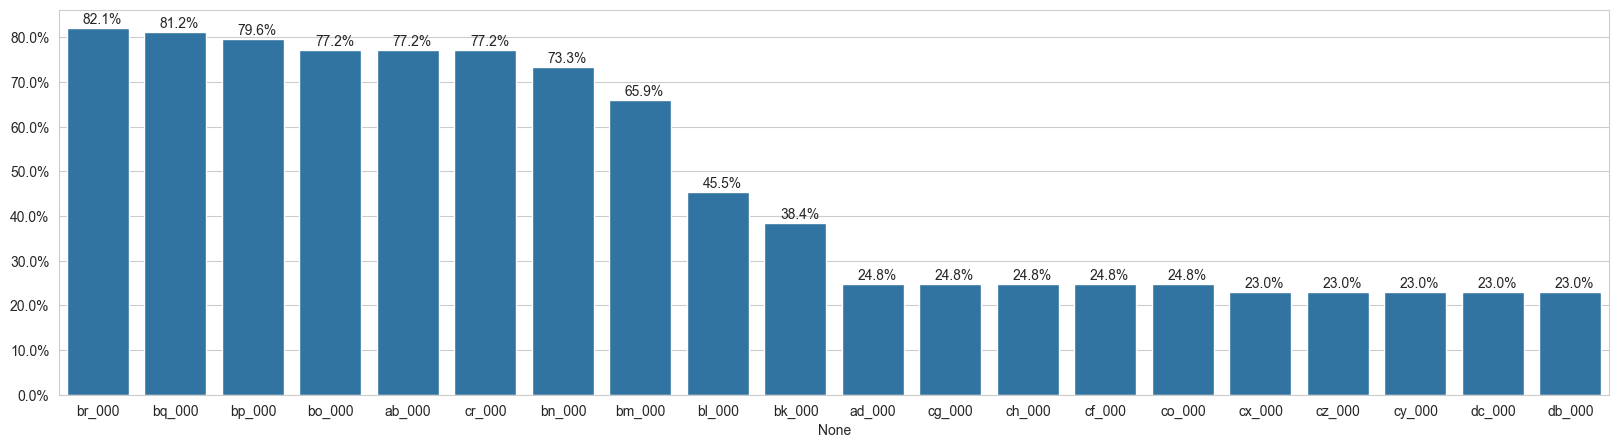

In [8]:

# Plotting a graph showing the top 20 features having highest percentage of missing values 
sns.set_style(style="whitegrid")
plt.figure(figsize=(20,5))

# Plot top 20 missing values
data_to_plot = missing_percentages.head(20)
plot = sns.barplot(x=data_to_plot.index, y=data_to_plot.values)

# Add annotations above each bar signifying their value (Shetty, 2021)
for p in plot.patches:
        plot.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+1))

# Make y-axis more interpretable (Shetty, 2021)
plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs())) 
plt.show()

#### Key observations:

1. High Missing Value Percentages (>70%): Several features (br_000, bq_000, bp_000, bo_000, ab_000, cr_000, bn_000) have extremely high missing value rates, ranging from 73.3% to 82.1%
The highest missing rate is 82.1% for feature br_000


2. Medium Missing Value Percentages (30-70%): Features bm_000, bl_000, and bk_000 show moderate to high missing values
- bm_000 has about 65.9% missing values
- bl_000 has 45.5% missing values
- bk_000 has 38.4% missing values


3. Low Missing Value Percentages (~24-23%): A large cluster of features (ad_000, cg_000, ch_000, cf_000, co_000, cx_000, cz_000, cy_000, dc_000, db_000) have consistent missing value rates around 23-24.8%

**This pattern suggests:**

* The data collection process might have systematic issues for certain sensors/measurements
* Features with very high missing values (>70%) might need to be dropped or require advanced imputation techniques
* The consistent ~24% missing rate across multiple features might indicate a systematic data collection issue or a specific operational condition where these measurements weren't recorded
* For machine learning purposes, handling these missing values will be crucial as they could significantly impact model performance

For this APS failure data, these missing values might represent sensor failures or conditions where measurements couldn't be taken during vehicle operation. 

#### 1.3 Handle Missing Values

##### 1.3.1 Remove features with > 70% missing values

In [9]:
columns_to_drop = missing_percentages[missing_percentages > 70].index
training_data = training_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)
print(f"Columns dropped: \n {columns_to_drop}\n\n")
print(f"Training Data Shape: {training_data.shape}\n")
print(f"Testing  Data Shape: {test_data.shape}")

Columns dropped: 
 Index(['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000'], dtype='object')


Training Data Shape: (60000, 164)

Testing  Data Shape: (16000, 164)


##### 1.3.2 Drop rows for features with <5% missing values

In [9]:
# # For features with <5% missing values, drop rows
# # columns_low_missing = missing_percentages[(missing_percentages > 0) & (missing_percentages < 5)].index
# columns_low_missing = missing_percentages[missing_percentages < 5].index
# training_data = training_data.dropna(subset=columns_low_missing)
# test_data = test_data.dropna(subset=columns_low_missing)

# print(f"Columns with rows < 5% dropped: \n {columns_low_missing}\n\n")
# print(f"Training Data Shape: {training_data.shape}\n")
# print(f"Testing  Data Shape: {test_data.shape}")

Columns with rows < 5% dropped: 
 Index(['bd_000', 'ds_000', 'dt_000', 'dr_000', 'du_000', 'dq_000', 'dp_000',
       'dv_000', 'bc_000', 'cp_000',
       ...
       'am_0', 'bi_000', 'ao_000', 'aq_000', 'bj_000', 'by_000', 'ck_000',
       'cj_000', 'ci_000', 'bt_000'],
      dtype='object', length=127)


Training Data Shape: (55936, 164)

Testing  Data Shape: (14891, 164)


##### 1.3.3 Apply median imputation for features with 5-15% missing values

In [10]:

# Seperating the class label from the other attributes after the NAN rows/columns were deleted
y_train = training_data['class']
X_train = training_data.drop('class',axis=1)

In [12]:
def imputation(df,mis_col):
    """
    This function imputes Missing values 
    using Median on given features, and
    Model Based Imputation on the rest
    
    """
    
    # Using sklearn's SimpleImputer
    median_imputer = SimpleImputer(missing_values=np.nan , strategy='median',copy=True)

    # Creating a new dataframe of imputed values
    median_df = median_imputer.fit_transform(df[mis_col])
    df1 = df.copy()
    df1[mis_col] = median_df

    # Performing Model-Based Imputation
    mice_imputer = IterativeImputer(estimator=Ridge(random_state=0),
                                    random_state=0)
    imputed_df = pd.DataFrame(data = mice_imputer.fit_transform(df1) , columns= df1.columns )

    return imputed_df , median_imputer , mice_imputer


# List of feature names that have missing values between 5% to 15%.
# We will impute the missing values in features with their median
median_imputed_features = [k for k,v in missing_percentages.items() if  v <= 15]

imputed_x_train , MEDIAN_imputer , MICE_imputer = imputation( X_train , median_imputed_features )
print("Number of features whose missing values are imputed with median are:\n",len(median_imputed_features))

KeyError: "['class'] not in index"

In [ ]:
# For features with 5-15% missing values, use median imputation
columns_median_impute = missing_percentages[(missing_percentages >= 5) & (missing_percentages < 15)].index
imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=True)

training_data[columns_median_impute] = imputer.fit_transform(training_data[columns_median_impute])
test_data[columns_median_impute] = imputer.transform(test_data[columns_median_impute])

print(f"Features with 5-15% missing values imputed: \n {columns_median_impute}\n\n")
print(f"Training Data Shape: {training_data.shape}\n")
print(f"Testing  Data Shape: {test_data.shape}")

Features with 5-15% missing values imputed: 
 Index(['ak_000', 'ca_000', 'dm_000', 'dl_000', 'dg_000', 'df_000', 'dh_000',
       'eb_000', 'dj_000', 'dk_000', 'di_000', 'ac_000', 'bx_000', 'cc_000'],
      dtype='object')


Training Data Shape: (55936, 164)

Testing  Data Shape: (14891, 164)


##### 1.3.4 Use Multiple Imputation by Chained Equations (MICE) for features with 15-70% missing values

In [11]:
# Side Note: For the 15-70% missing values, `MICE` can be used, but it's computationally intensive
# For simplicity, we'll use median imputation
columns_mice = missing_percentages[(missing_percentages >= 15) & (missing_percentages <= 70)].index
training_data[columns_mice] = imputer.fit_transform(training_data[columns_mice])

print(f"Features with 15-70% missing values imputed: \n {columns_mice}\n\n")
print(f"Training Data Shape: {training_data.shape}\n")
print(f"Testing  Data Shape: {test_data.shape}")

Features with 15-70% missing values imputed: 
 Index(['bm_000', 'bl_000', 'bk_000', 'ad_000', 'cg_000', 'ch_000', 'cf_000',
       'co_000', 'cx_000', 'cz_000', 'cy_000', 'dc_000', 'db_000', 'cv_000',
       'ct_000', 'da_000', 'cu_000', 'ec_00', 'cm_000', 'cl_000', 'ed_000'],
      dtype='object')


Training Data Shape: (55936, 164)

Testing  Data Shape: (14891, 164)


### 1.4 Perform Feature Engineering

##### 1.4.1 Separate histogram bin features from numerical features

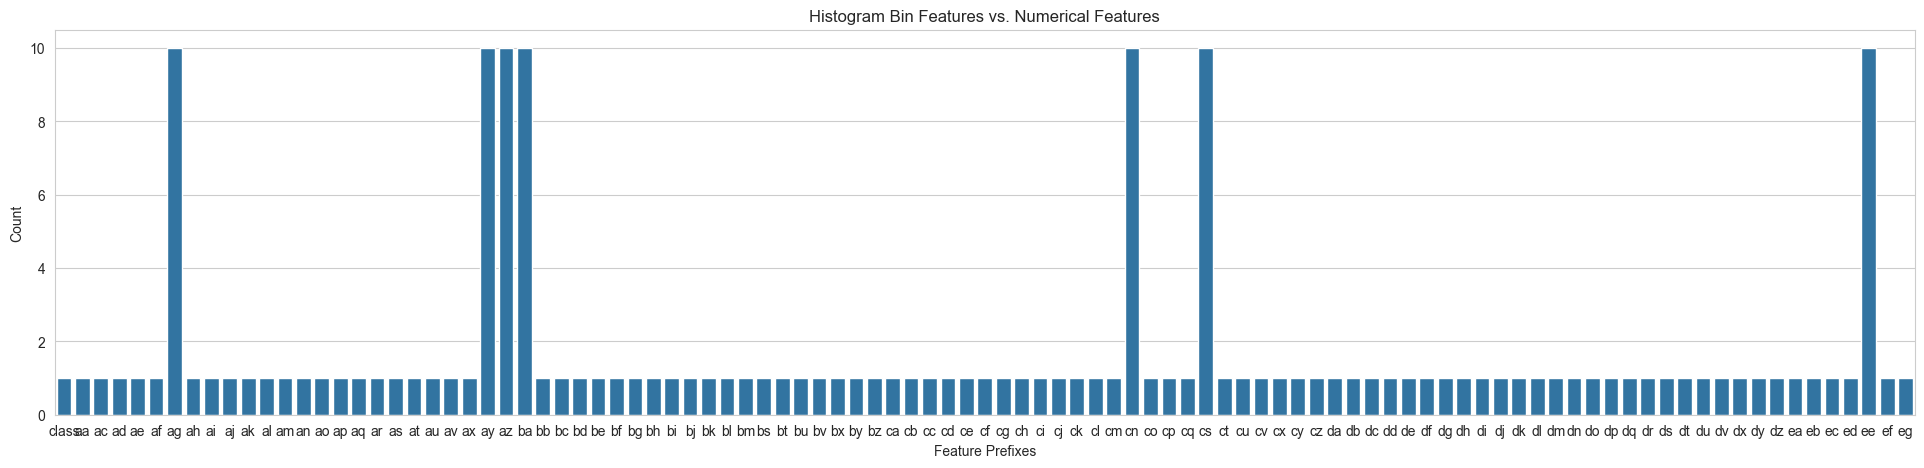

In [12]:
# Extract feature prefixes
feature_prefix_counts = Counter([name.split('_')[0] for name in training_data.columns])

# Get unique feature prefixes and their counts
feature_prefixes = list(feature_prefix_counts.keys())
bin_counts = list(feature_prefix_counts.values())

# Plot the feature distribution
plt.figure(figsize=(24, 5))
sns.barplot(x=feature_prefixes, y=bin_counts)
plt.xlabel("Feature Prefixes")
plt.ylabel("Count")
plt.title("Histogram Bin Features vs. Numerical Features")
plt.show()

In [13]:
# Identify histogram features based on bin count
hist_identifiers = [prefix for prefix, count in zip(feature_prefixes, bin_counts) if count == 10]
print("The Histogram Identifiers are:", hist_identifiers)

# Extract feature names containing histogram bin information
hist_features = [col for col in training_data.columns if col.split('_')[0] in hist_identifiers]
print(f"\nThere are {len(hist_features)} features that contain histogram bin information:\n{hist_features}")


The Histogram Identifiers are: ['ag', 'ay', 'az', 'ba', 'cn', 'cs', 'ee']

There are 70 features that contain histogram bin information:
['ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'cn_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_005', 'cn_006', 'cn_007', 'cn_008', 'cn_009', 'cs_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005', 'cs_006', 'cs_007', 'cs_008', 'cs_009', 'ee_000', 'ee_001', 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008', 'ee_009']


7 sets of features were identified

##### 1.4.2 Create binary features to indicate originally missing values

In [14]:
# Create binary features for originally missing values
for col in training_data.columns:
    if training_data[col].isnull().sum() > 0:
        training_data[f'{col}_was_missing'] = training_data[col].isnull().astype(int)

##### 1.4.3 Split Training Dataset to training and target sets

In [15]:
X_train = training_data.drop('class', axis=1)
y_train = training_data.loc[:, 'class']

##### 1.4.3 Separate histogram bin features from numerical features

In [16]:
# Separating the top features from the datasets
histogram_data = X_train[hist_features]
x_without_hist = X_train.drop(hist_features,axis=1)

histogram_data

,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,...,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009
0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,...,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0
1,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,...,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0
2,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,...,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0
3,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,...,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,...,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,2564.0,59100.0,1603216.0,6015982.0,1968266.0,164972.0,12560.0,...,1608808.0,1479066.0,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0
59996,0.0,0.0,0.0,0.0,104.0,99186.0,36564.0,128.0,0.0,0.0,...,13934.0,15024.0,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,28.0,11592.0,11538.0,0.0,0.0,0.0,...,15876.0,2740.0,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,330.0,202498.0,3251010.0,2061456.0,360436.0,59754.0,...,1180714.0,1709450.0,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0


### 2. Exploratory Data Analysis (EDA)

#### 2.1 Visualize feature distributions and correlations

In [17]:
# Top features of histogram
histogram_data.columns[:20]

Index(['ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006',
       'ag_007', 'ag_008', 'ag_009', 'ay_000', 'ay_001', 'ay_002', 'ay_003',
       'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009'],
      dtype='object')

In [18]:
# inspect shape
if(histogram_data.shape[0] != y_train.shape[0]):
    raise ValueError("Length of datasets out of proportion!")

In [19]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
n_features_to_select = 20
estimator = RandomForestClassifier(n_estimators=100, 
                                   max_depth=7, 
                                   min_samples_split=3, 
                                   random_state=42)
# Initialize the RFE selector with a different RandomForest configuration
selector = RFE(
    estimator= estimator,
    n_features_to_select=n_features_to_select,
    step=1,  # Selecting one feature at a time per iteration
    verbose=3
)

# Fit the selector on the dataset
selector.fit(histogram_data, y_train)

# Extract the selected feature names
selected_features = histogram_data.columns[selector.support_].tolist()

print(f"Top {n_features_to_select} selected features:\n{selected_features}")


Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

In [34]:
# Selected features
selected_features_df = X_train.loc[:, selected_features].copy()
selected_features_df.loc[:, 'class'] = y_train.copy()
selected_features_df

,ag_001,ag_002,ag_003,ay_005,ay_006,ay_008,ay_009,ba_002,ba_003,ba_004,...,cn_000,cn_001,cn_004,cs_002,cs_004,cs_005,ee_000,ee_003,ee_005,class
0,0.0,0.0,0.0,469014.0,4239660.0,755876.0,0.0,415432.0,287230.0,310246.0,...,0.0,0.0,1309472.0,267998.0,428776.0,4015854.0,965866.0,493384.0,469792.0,neg
1,0.0,0.0,0.0,71510.0,772720.0,99560.0,0.0,199512.0,154298.0,137280.0,...,0.0,0.0,1179502.0,164860.0,272956.0,1837600.0,664504.0,178064.0,245416.0,neg
2,0.0,0.0,0.0,0.0,870456.0,1450312.0,0.0,332340.0,254892.0,189596.0,...,0.0,0.0,1215280.0,56362.0,100326.0,1744838.0,262032.0,159812.0,409564.0,neg
3,0.0,0.0,318.0,0.0,0.0,5596.0,0.0,304.0,102.0,74.0,...,0.0,52.0,2170.0,24.0,692.0,4836.0,5670.0,46.0,44.0,neg
4,0.0,0.0,0.0,372236.0,2128914.0,584074.0,0.0,338762.0,236540.0,182278.0,...,0.0,0.0,2497104.0,80950.0,186242.0,2288268.0,404740.0,229790.0,347188.0,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,2564.0,45114.0,2533260.0,4705948.0,0.0,917904.0,744468.0,580332.0,...,0.0,860.0,3156012.0,138036.0,425276.0,5875496.0,1608808.0,566884.0,1218244.0,neg
59996,0.0,0.0,0.0,4610.0,99120.0,20960.0,0.0,17376.0,8610.0,2990.0,...,0.0,0.0,63554.0,3606.0,2112.0,40190.0,13934.0,6760.0,68424.0,neg
59997,0.0,0.0,0.0,0.0,0.0,22454.0,0.0,856.0,490.0,162.0,...,0.0,0.0,14690.0,72.0,5348.0,14382.0,15876.0,386.0,144.0,neg
59998,0.0,0.0,0.0,119742.0,4445146.0,0.0,0.0,385878.0,287818.0,239818.0,...,0.0,0.0,760936.0,333922.0,388092.0,3174954.0,1180714.0,222654.0,225724.0,neg


#### 2.2 Analyze class imbalance (59,000 negative vs. 1,000 positive cases)


Performing EDA...


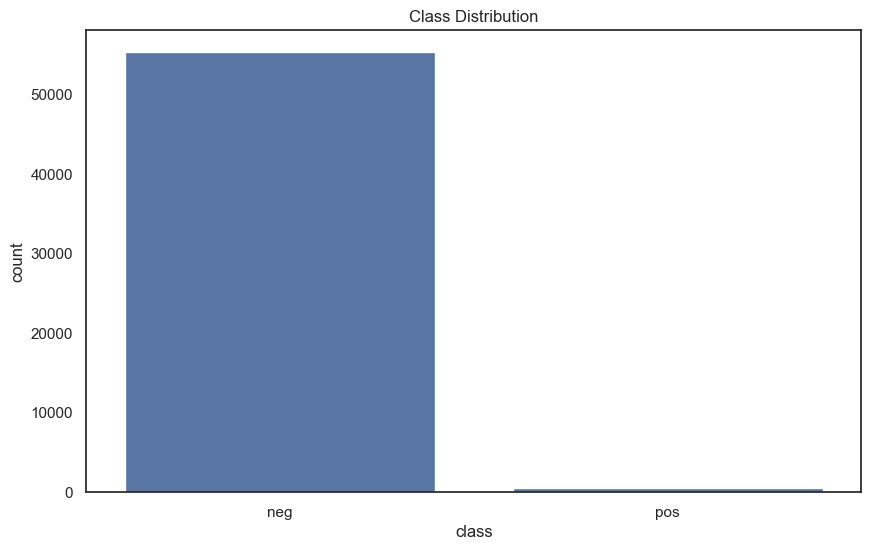

In [35]:
print("\nPerforming EDA...")
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=training_data)
plt.title('Class Distribution')
plt.savefig('class_distribution.png')
plt.show()

#### 2.3 Identify potential key indicators of APS failures through statistical analysis:

##### 2.3.1 Correlation analysis

In [36]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

selected_features_df['class'] = encoder.fit_transform(selected_features_df['class'])

selected_features_df['class'].unique()

array([0, 1])

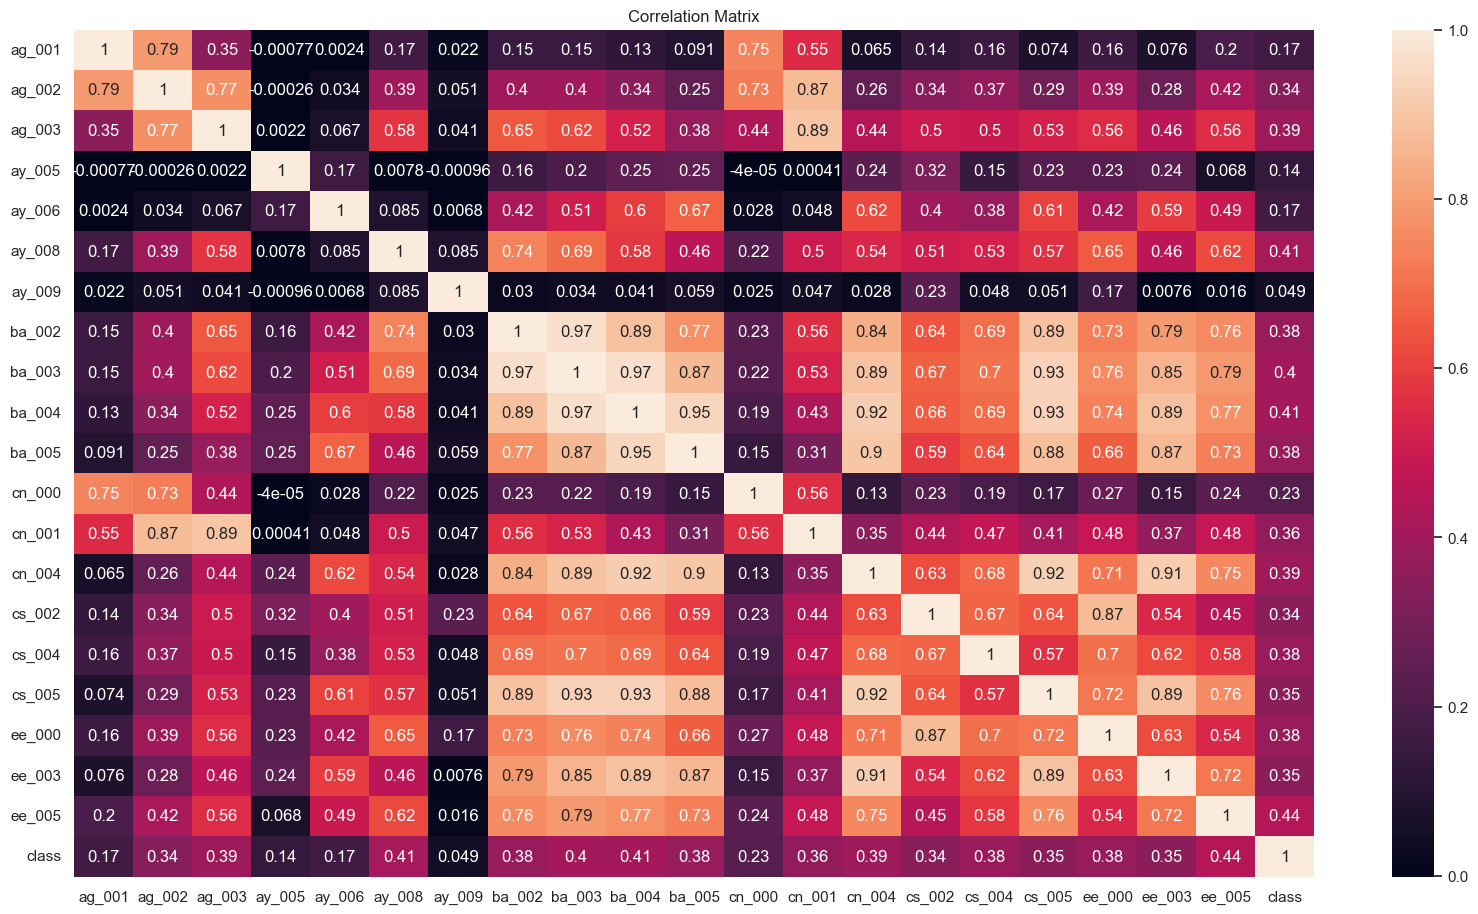

In [37]:
# Plot Correlation Heatmap      
plt.figure(figsize=(20,11))
sns.heatmap(selected_features_df.corr(),annot=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Getting correlation coeffiecients of features w.r.t class
correlation_values = selected_features_df.corr().loc['class']
print(correlation_values)
# Get top 5 features
top_correlated_features = correlation_values.sort_values().index.tolist()
print("Most Uncorrelated Feature is",top_correlated_features[0])

ag_001    0.174666
ag_002    0.339138
ag_003    0.390425
ay_005    0.136290
ay_006    0.172567
ay_008    0.412295
ay_009    0.048968
ba_002    0.380644
ba_003    0.404811
ba_004    0.409133
ba_005    0.376218
cn_000    0.225641
cn_001    0.363517
cn_004    0.392643
cs_002    0.343887
cs_004    0.382593
cs_005    0.352727
ee_000    0.380476
ee_003    0.351342
ee_005    0.442683
class     1.000000
Name: class, dtype: float64
Most Uncorrelated Feature is ay_009


Feature: 'ag_001', Class 1 - Mean: 42503.54, Std Dev: 232360.91
Feature: 'ag_001', Class 0 - Mean: 114.30, Std Dev: 5282.42



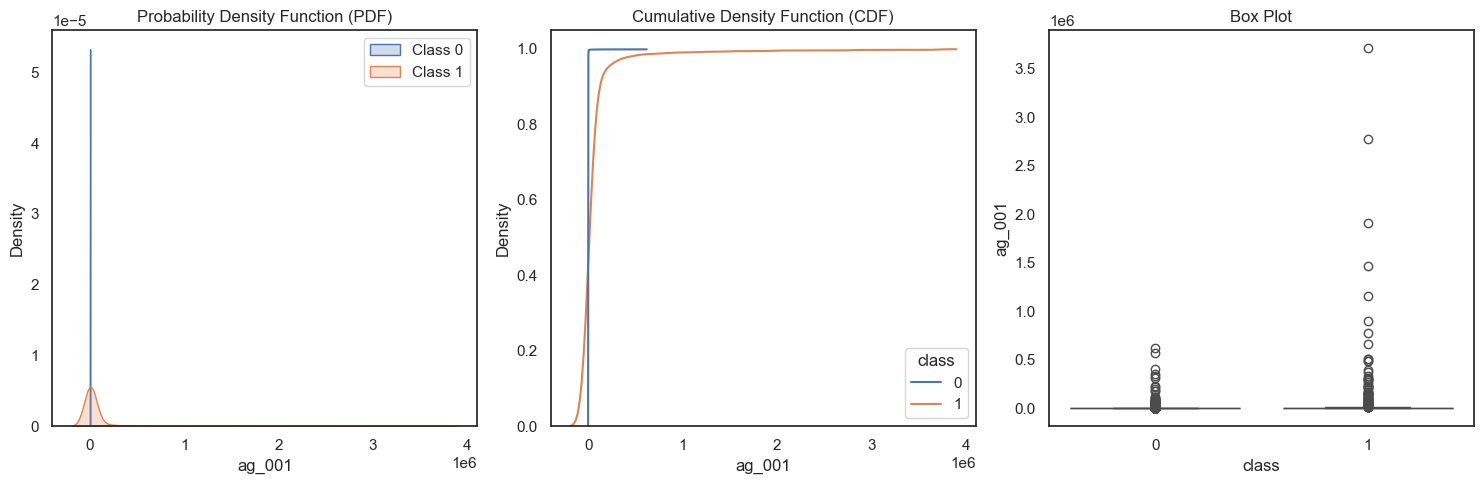

****************************************************************************************************
Feature: 'ag_002', Class 1 - Mean: 320375.83, Std Dev: 822733.38
Feature: 'ag_002', Class 0 - Mean: 1203.58, Std Dev: 32775.85



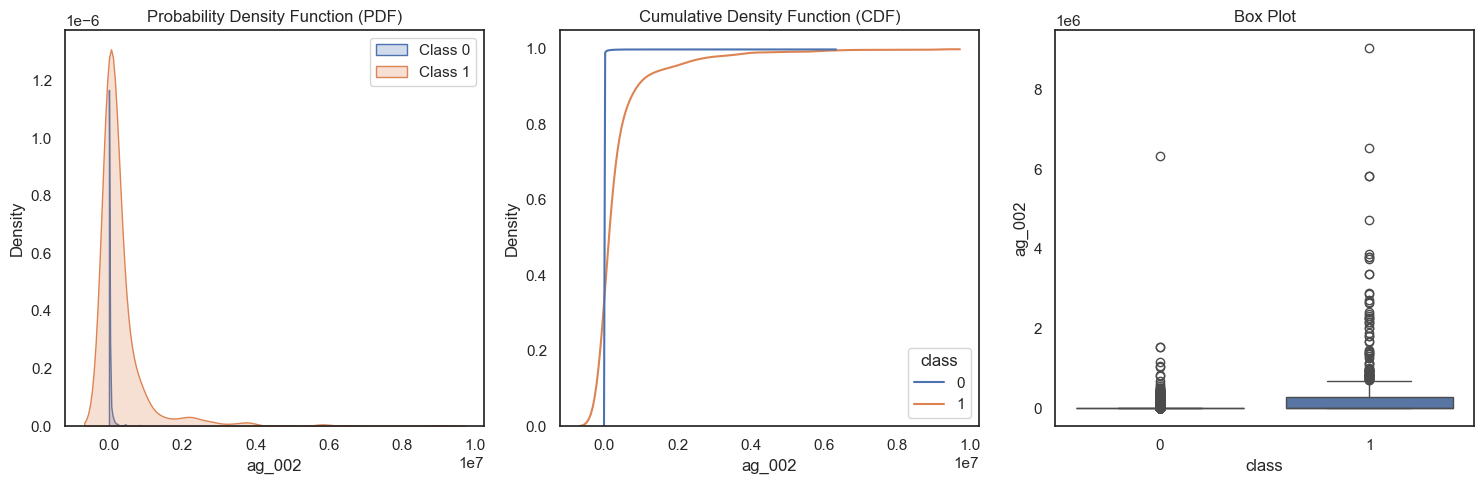

****************************************************************************************************
Feature: 'ag_003', Class 1 - Mean: 2038674.17, Std Dev: 3278082.14
Feature: 'ag_003', Class 0 - Mean: 29737.17, Std Dev: 351525.87



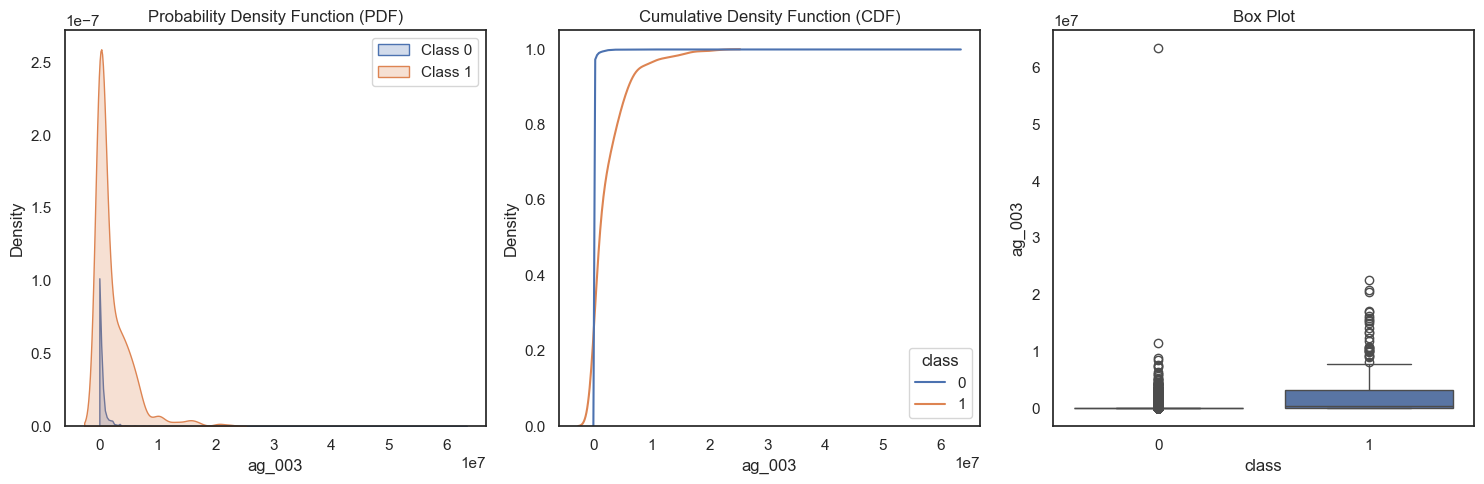

****************************************************************************************************
Feature: 'ay_005', Class 1 - Mean: 1034242.09, Std Dev: 4858700.79
Feature: 'ay_005', Class 0 - Mean: 54456.29, Std Dev: 535373.83



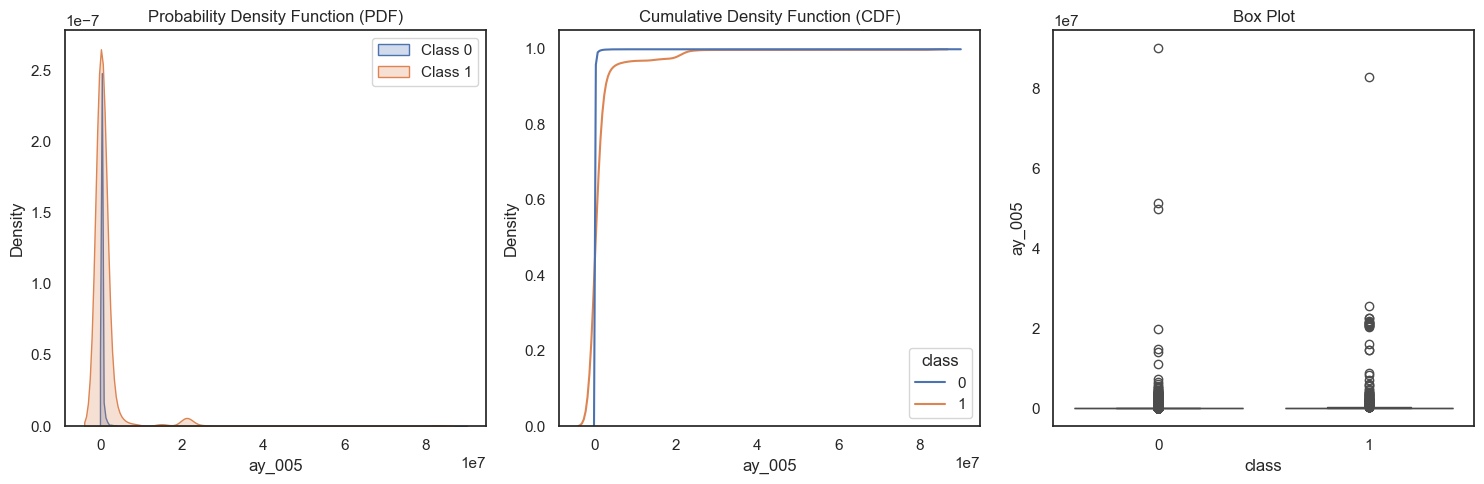

****************************************************************************************************
Feature: 'ay_006', Class 1 - Mean: 4650066.56, Std Dev: 10313604.80
Feature: 'ay_006', Class 0 - Mean: 886208.76, Std Dev: 1942744.29



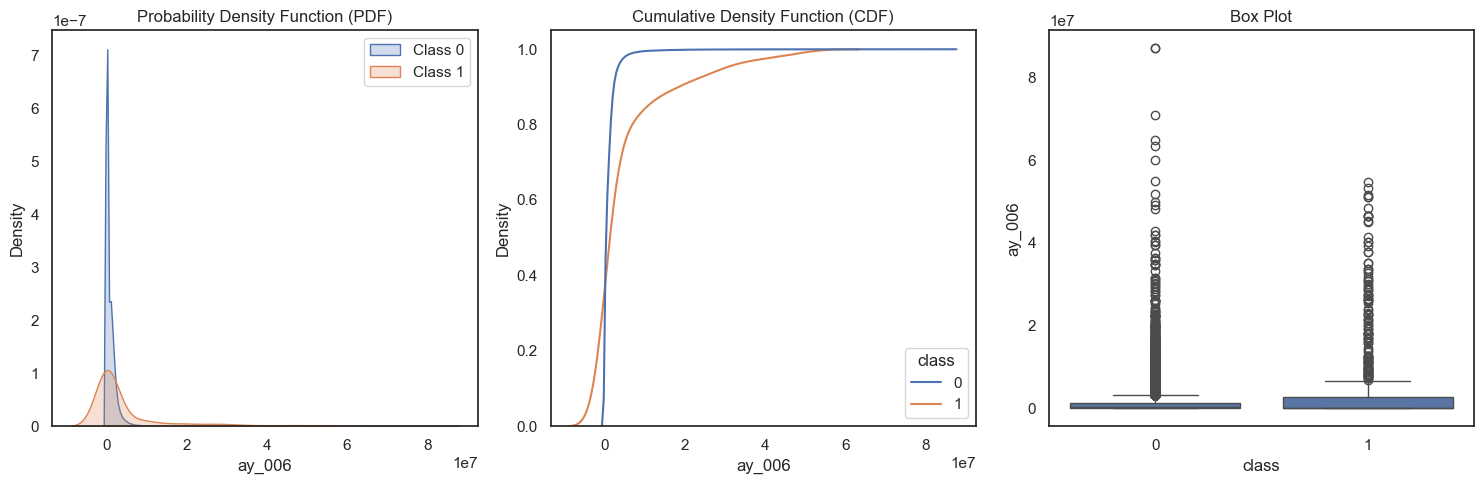

****************************************************************************************************
Feature: 'ay_008', Class 1 - Mean: 12522092.96, Std Dev: 14692657.97
Feature: 'ay_008', Class 0 - Mean: 669475.38, Std Dev: 2233374.96



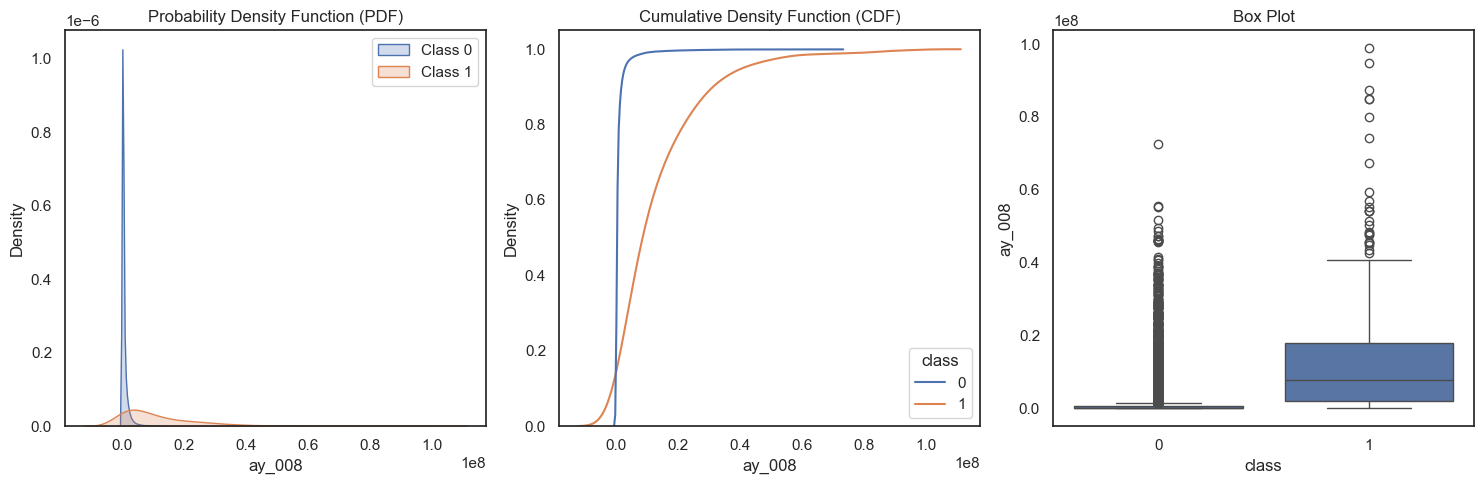

****************************************************************************************************
Feature: 'ay_009', Class 1 - Mean: 48721.72, Std Dev: 518489.28
Feature: 'ay_009', Class 0 - Mean: 648.16, Std Dev: 85758.08



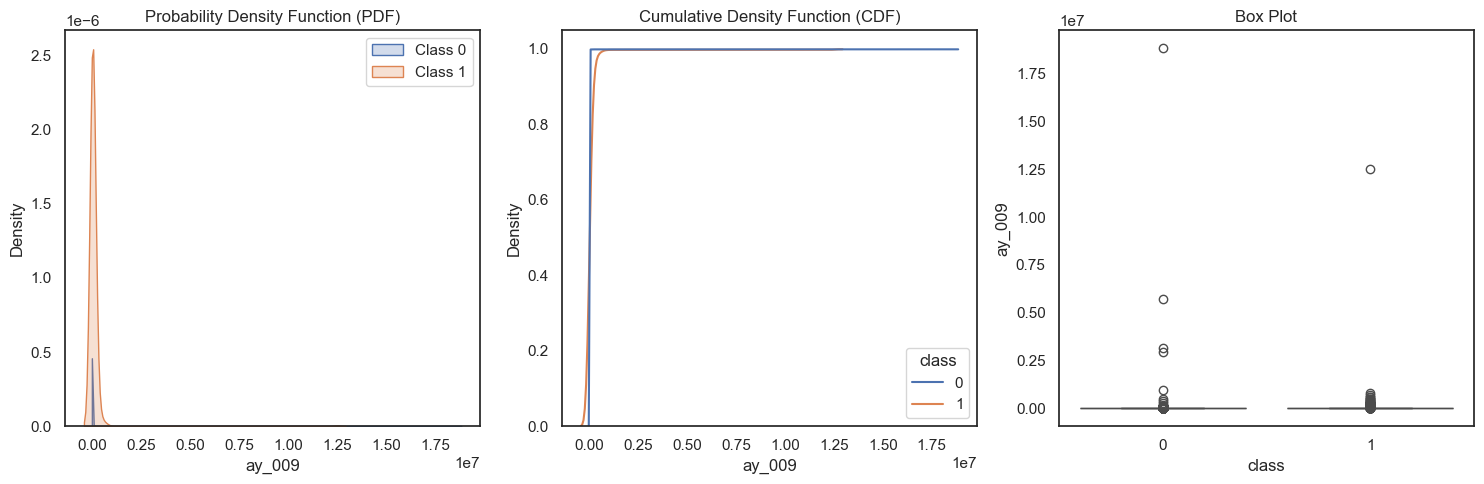

****************************************************************************************************
Feature: 'ba_002', Class 1 - Mean: 3117128.09, Std Dev: 2908748.30
Feature: 'ba_002', Class 0 - Mean: 275671.24, Std Dev: 645566.26



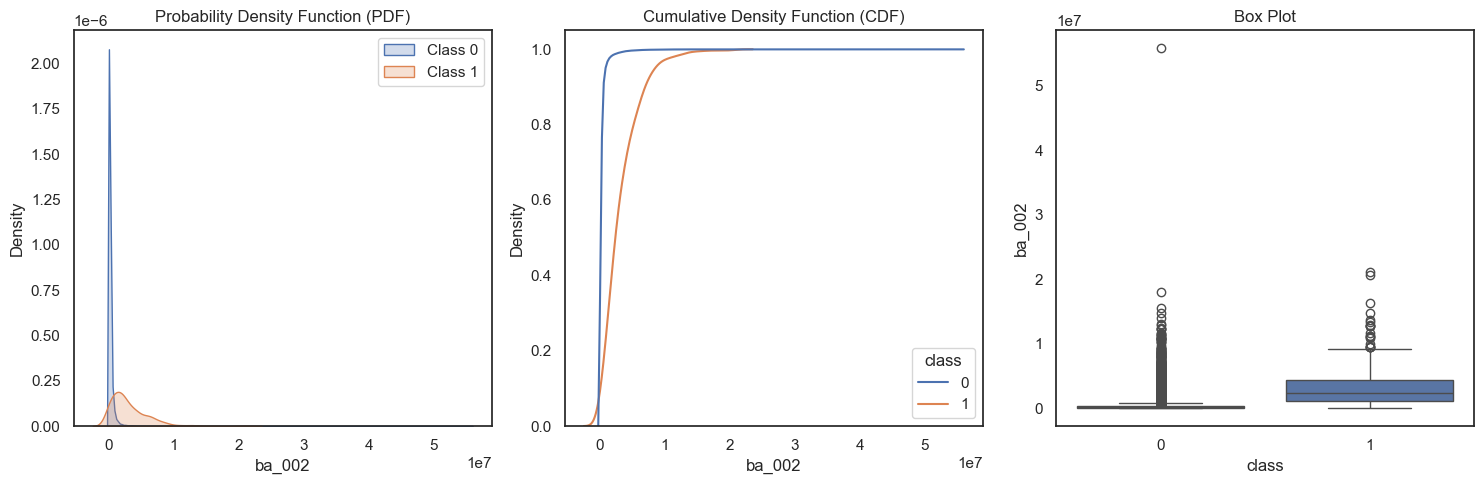

****************************************************************************************************
Feature: 'ba_003', Class 1 - Mean: 2099777.07, Std Dev: 1947424.14
Feature: 'ba_003', Class 0 - Mean: 187939.87, Std Dev: 397416.70



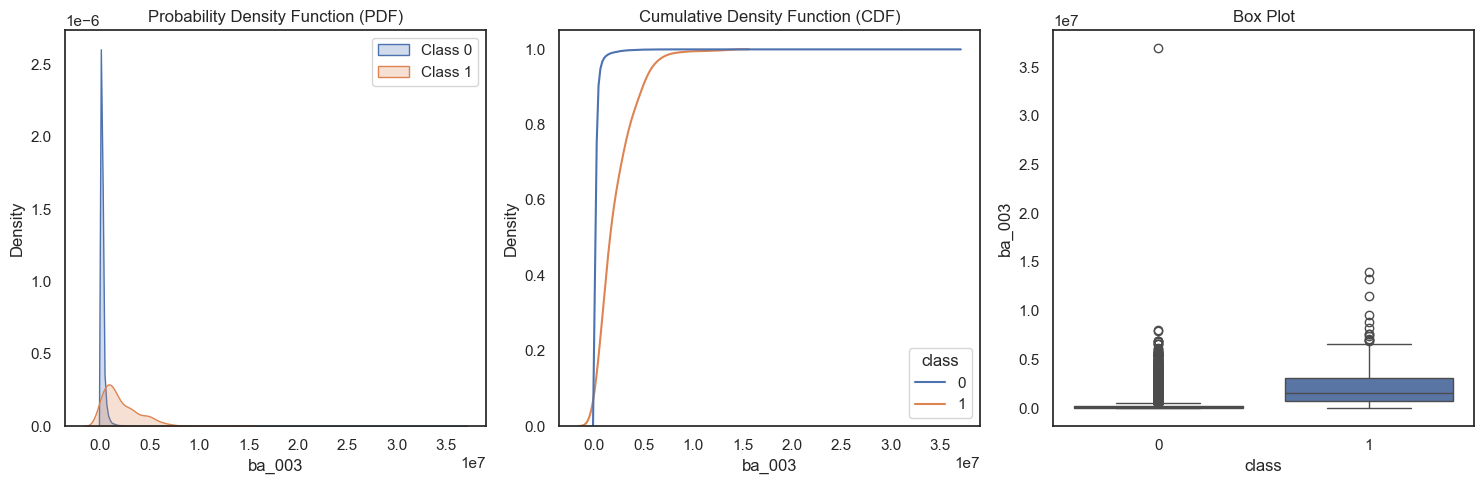

****************************************************************************************************
Feature: 'ba_004', Class 1 - Mean: 1571623.13, Std Dev: 1522554.80
Feature: 'ba_004', Class 0 - Mean: 144598.43, Std Dev: 288104.64



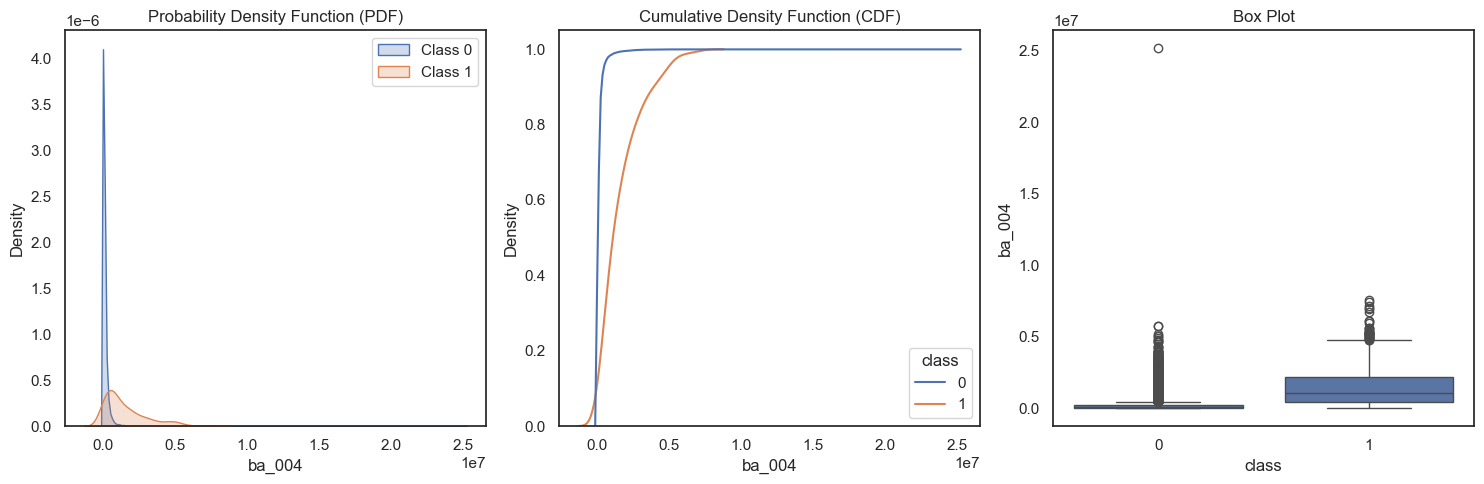

****************************************************************************************************
Feature: 'ba_005', Class 1 - Mean: 1405712.78, Std Dev: 1538713.21
Feature: 'ba_005', Class 0 - Mean: 137163.99, Std Dev: 280249.26



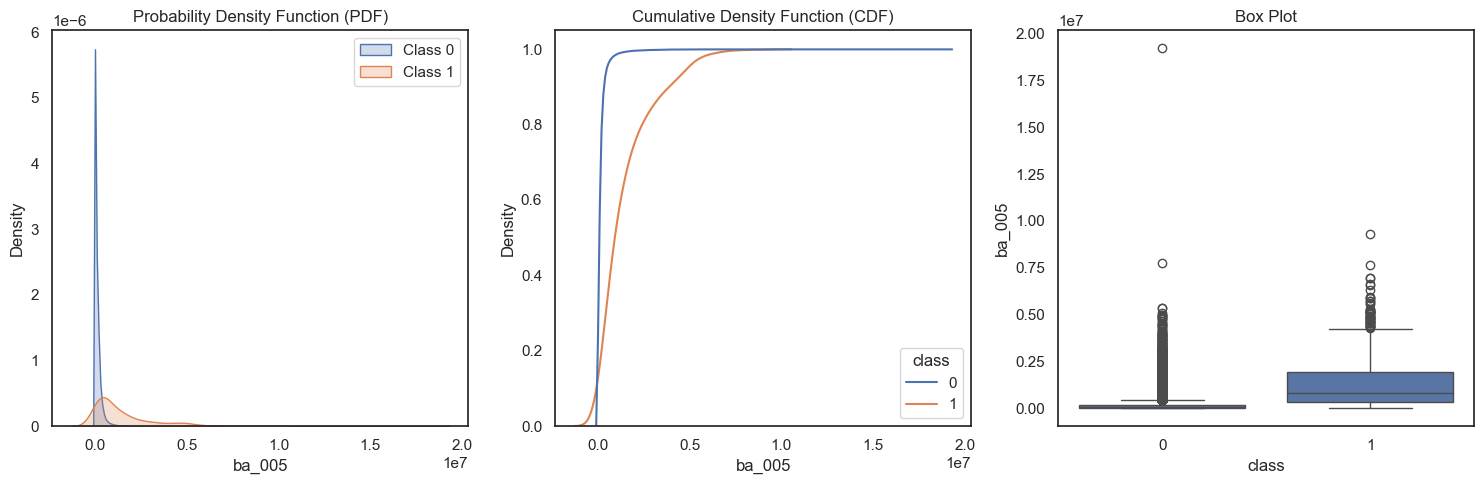

****************************************************************************************************
Feature: 'cn_000', Class 1 - Mean: 116715.71, Std Dev: 471065.04
Feature: 'cn_000', Class 0 - Mean: 410.86, Std Dev: 17345.77



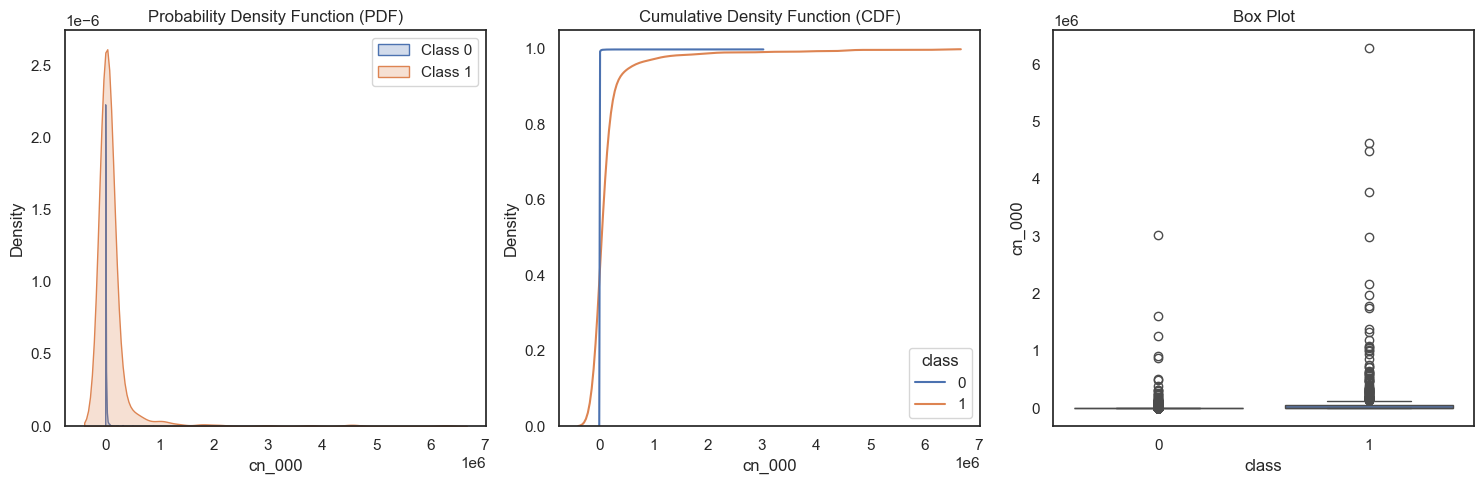

****************************************************************************************************
Feature: 'cn_001', Class 1 - Mean: 601751.97, Std Dev: 1248819.20
Feature: 'cn_001', Class 0 - Mean: 6571.83, Std Dev: 89559.22



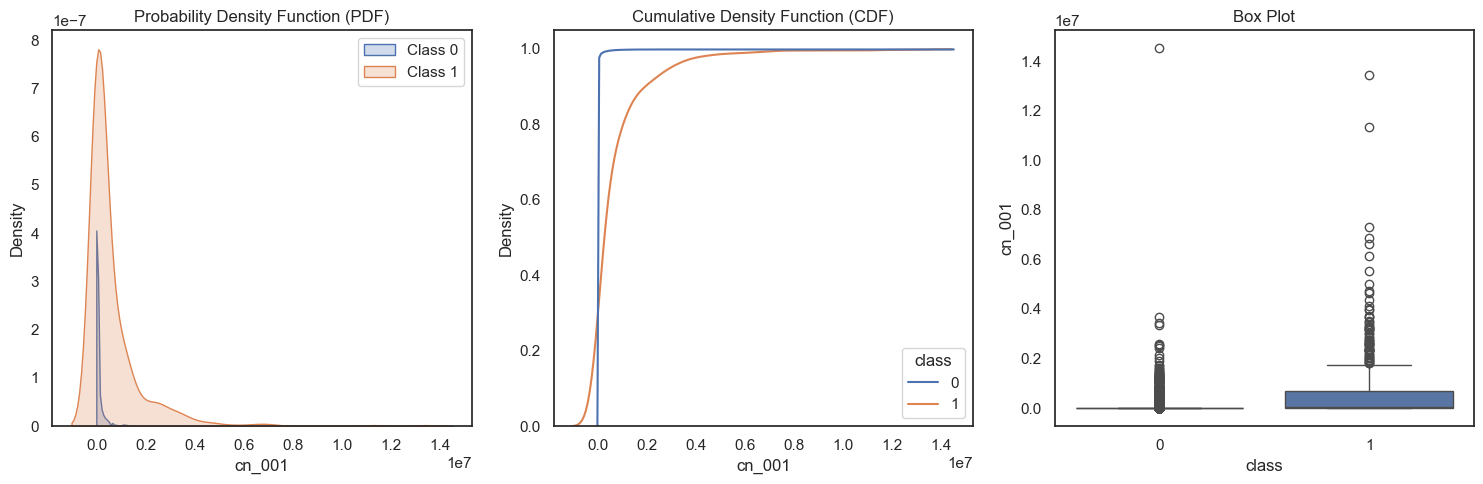

****************************************************************************************************
Feature: 'cn_004', Class 1 - Mean: 9901680.81, Std Dev: 10102304.72
Feature: 'cn_004', Class 0 - Mean: 900391.82, Std Dev: 1907676.85



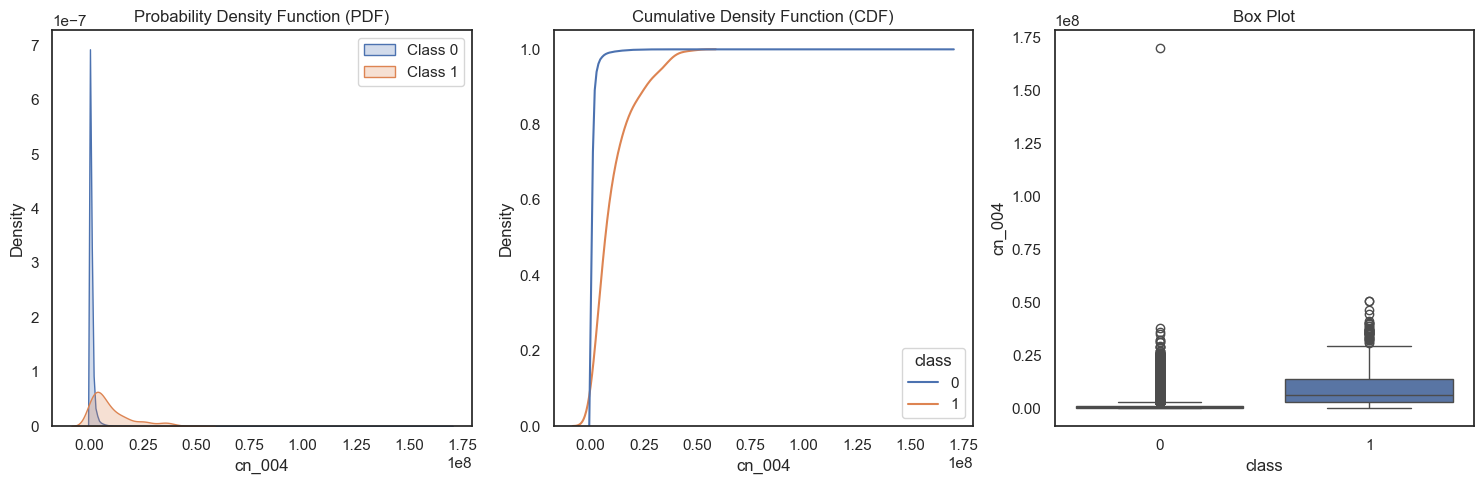

****************************************************************************************************
Feature: 'cs_002', Class 1 - Mean: 2905755.64, Std Dev: 3685371.14
Feature: 'cs_002', Class 0 - Mean: 125999.32, Std Dev: 683998.05



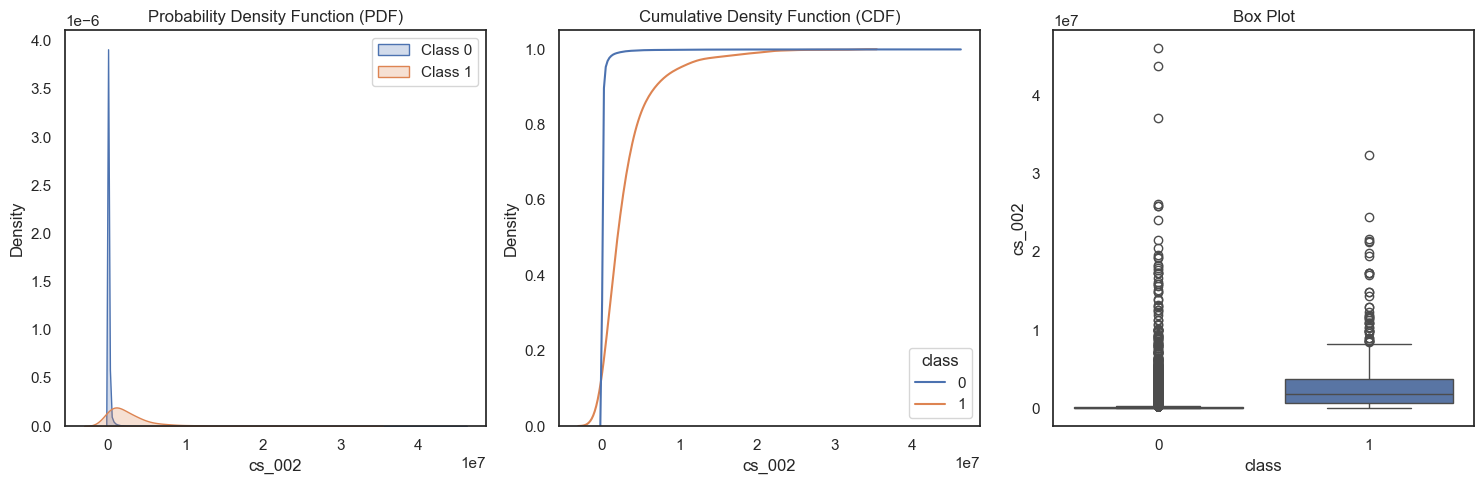

****************************************************************************************************
Feature: 'cs_004', Class 1 - Mean: 5780159.69, Std Dev: 8907309.94
Feature: 'cs_004', Class 0 - Mean: 241617.11, Std Dev: 1026175.11



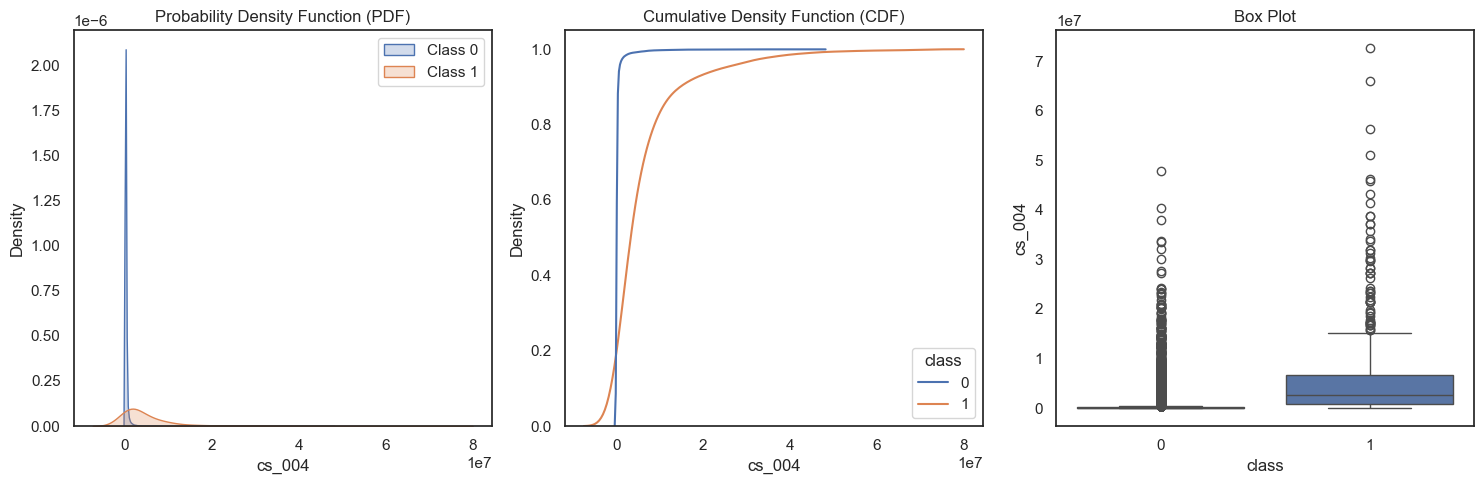

****************************************************************************************************
Feature: 'cs_005', Class 1 - Mean: 15672290.56, Std Dev: 14709311.81
Feature: 'cs_005', Class 0 - Mean: 1625876.89, Std Dev: 3531092.49



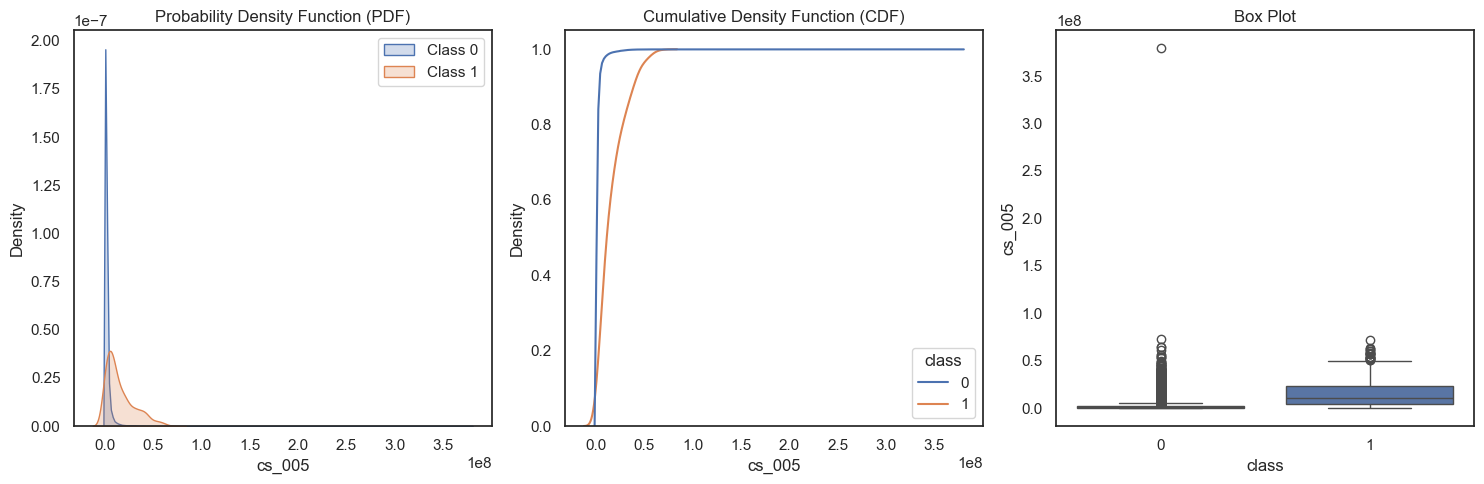

****************************************************************************************************
Feature: 'ee_000', Class 1 - Mean: 6310590.16, Std Dev: 6934620.19
Feature: 'ee_000', Class 0 - Mean: 487278.20, Std Dev: 1271866.15



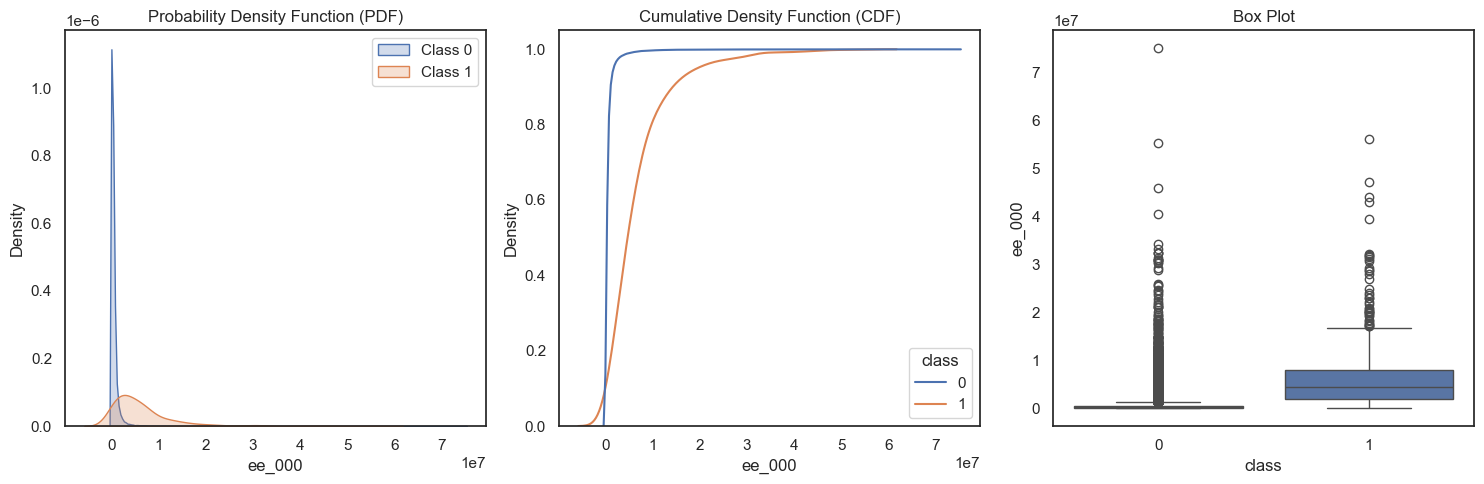

****************************************************************************************************
Feature: 'ee_003', Class 1 - Mean: 1586282.44, Std Dev: 1900148.65
Feature: 'ee_003', Class 0 - Mean: 159650.54, Std Dev: 339373.81



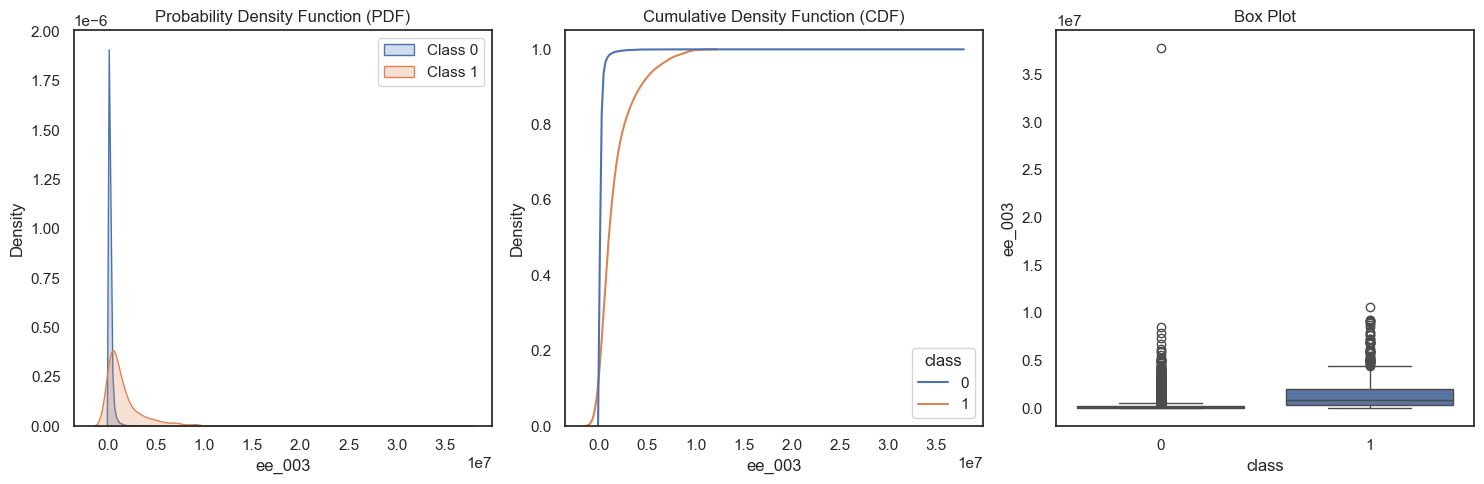

****************************************************************************************************
Feature: 'ee_005', Class 1 - Mean: 3597279.10, Std Dev: 4318345.11
Feature: 'ee_005', Class 0 - Mean: 286948.81, Std Dev: 527788.92



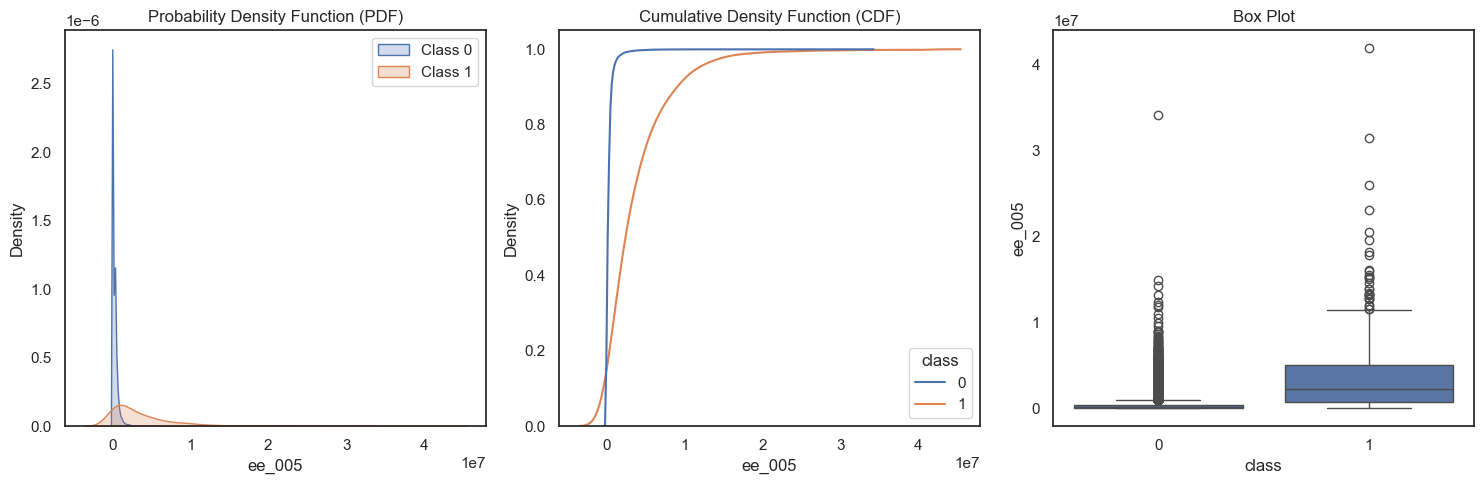

****************************************************************************************************


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing features by class
for feature in selected_features_df.columns:
    if feature != 'class':
        # Compute statistics for each class
        stats_class_0 = selected_features_df[selected_features_df['class'] == 0][feature].describe()
        stats_class_1 = selected_features_df[selected_features_df['class'] == 1][feature].describe()

        # Print mean and standard deviation for both classes
        print(f"\033[1mFeature: '{feature}', Class 1 - Mean: {stats_class_1['mean']:.2f}, Std Dev: {stats_class_1['std']:.2f}")
        print(f"Feature: '{feature}', Class 0 - Mean: {stats_class_0['mean']:.2f}, Std Dev: {stats_class_0['std']:.2f}\n")

        # Set up the figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        sns.set_theme(style='white')

        # Plot PDF of the feature for both classes
        sns.kdeplot(x=selected_features_df[selected_features_df['class'] == 0][feature], ax=axes[0], label="Class 0", shade=True)
        sns.kdeplot(x=selected_features_df[selected_features_df['class'] == 1][feature], ax=axes[0], label="Class 1", shade=True)
        axes[0].set_title("Probability Density Function (PDF)")
        axes[0].legend()

        # Plot CDF of the feature
        sns.kdeplot(data=selected_features_df, x=feature, hue="class", cumulative=True, common_norm=False, ax=axes[1])
        axes[1].set_title("Cumulative Density Function (CDF)")

        # Plot Box-Plot of the feature
        sns.boxplot(x=selected_features_df['class'], y=selected_features_df[feature], ax=axes[2])
        axes[2].set_title("Box Plot")

        # Display the plots
        plt.tight_layout()
        plt.show()
        
        print('*' * 100)


In [45]:
selected_features_df['ay_005']

0        469014.0
1         71510.0
2             0.0
3             0.0
4        372236.0
           ...   
59995     45114.0
59996      4610.0
59997         0.0
59998    119742.0
59999    105702.0
Name: ay_005, Length: 55936, dtype: float64

In [26]:
selected_features_df.head()

,ag_001,ag_002,ag_003,ay_005,ay_006,ay_008,ay_009,ba_002,ba_003,ba_004,...,cn_000,cn_001,cn_004,cs_002,cs_004,cs_005,ee_000,ee_003,ee_005,class
0,0.0,0.0,0.0,469014.0,4239660.0,755876.0,0.0,415432.0,287230.0,310246.0,...,0.0,0.0,1309472.0,267998.0,428776.0,4015854.0,965866.0,493384.0,469792.0,0
1,0.0,0.0,0.0,71510.0,772720.0,99560.0,0.0,199512.0,154298.0,137280.0,...,0.0,0.0,1179502.0,164860.0,272956.0,1837600.0,664504.0,178064.0,245416.0,0
2,0.0,0.0,0.0,0.0,870456.0,1450312.0,0.0,332340.0,254892.0,189596.0,...,0.0,0.0,1215280.0,56362.0,100326.0,1744838.0,262032.0,159812.0,409564.0,0
3,0.0,0.0,318.0,0.0,0.0,5596.0,0.0,304.0,102.0,74.0,...,0.0,52.0,2170.0,24.0,692.0,4836.0,5670.0,46.0,44.0,0
4,0.0,0.0,0.0,372236.0,2128914.0,584074.0,0.0,338762.0,236540.0,182278.0,...,0.0,0.0,2497104.0,80950.0,186242.0,2288268.0,404740.0,229790.0,347188.0,0


In [27]:
# Define the feature for percentile filtering
columns = top_correlated_features + ['class']

df = selected_features_df[columns].copy()
df.head()

,ay_009,ay_005,ay_006,ag_001,cn_000,ag_002,cs_002,ee_003,cs_005,cn_001,class
0,0.0,469014.0,4239660.0,0.0,0.0,0.0,267998.0,493384.0,4015854.0,0.0,0
1,0.0,71510.0,772720.0,0.0,0.0,0.0,164860.0,178064.0,1837600.0,0.0,0
2,0.0,0.0,870456.0,0.0,0.0,0.0,56362.0,159812.0,1744838.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,24.0,46.0,4836.0,52.0,0
4,0.0,372236.0,2128914.0,0.0,0.0,0.0,80950.0,229790.0,2288268.0,0.0,0


In [28]:
top_correlated_features = top_correlated_features
top_correlated_features 

['ay_009',
 'ay_005',
 'ay_006',
 'ag_001',
 'cn_000',
 'ag_002',
 'cs_002',
 'ee_003',
 'cs_005',
 'cn_001']

In [29]:
features = top_correlated_features[0]
features

'ay_009'

In [42]:
p = np.nanpercentile(df[feature], 95)
df = df[df[feature] < p]
df.head()

,ay_009,ay_005,ay_006,ag_001,cn_000,ag_002,cs_002,ee_003,cs_005,cn_001,class


In [ ]:
fig,ax = plt.subplots(1,5,figsize=(19,4))
columns = df.columns.tolist()
for i in range(len(columns)):
    if columns[i] !='class':
        # Plot scatterplot between 2 given features
        sns.scatterplot(x=df[columns[i]],y=df[features],hue=df['class'],ax=ax[i])
plt.show()

## References:

Shetty, R. (2021). Predicting a Failure in Scania’s Air Pressure System. [online] Medium. Available at: https://towardsdatascience.com/predicting-a-failure-in-scanias-air-pressure-system-aps-c260bcc4d038 [Accessed 4 Jan. 2025].